# Intelligente systemer: Regresjon

Velkommen til denne notebooken som inngår i Høyskolen Kristianias emne «Utvikling og anvendelse av intelligente systemer», modul 2, «Veiledet læring».

## Hvordan du bruker denne notebooken
Dette er en Jupyter notebook med tekst og Python-kode som du kjører ved å trykke shift-enter. Hensikten er å bli kjent med relevante konsepter i praksis, ikke nødvendigvis å forstå alle detaljer i koden. Ta deg god tid til å lese teksten, se gjennom koden, kjøre kodecellene (pass på riktig rekkefølge), studere resultatene, og tenke gjennom hva vi gjør, hvorfor og hvordan.

Underveis i teksten vil du finne referanser til Canvas-oppgaver _i kursiv_. Gå til Canvas og besvar spørsmålene der før du går videre i notebooken.

![2res6turbines.png](attachment:697cce3c-632f-41db-a1b9-4fe92206559f.png)![2res6turbines.png](attachment:dfb3d728-45bf-4e87-bc5b-ad1d1956300b.png)## Problem: Fitting a water power plant with a neural net and boosted tree models
We consider a power plant with six generators each, with a power output of "P_i" ($P_i$).

In the figure below and in the data, "h_r1" ($h_1$) is the water level in the input reservoir, and "h_r2" ($h_2$) is the water level of the output reservoir. 

Each generator has a loss (efficiency), $\Delta h_i^{head}$, which is related to the individual production of all generators in a complicated way. In addition there is a loss below the turbines $\Delta h^{tail}$ (see the figure below).

**The challenge is to describe the individual (by generator) loss given the production from all generators**. Such a model could be used to optimize the production scheduling between the generators in a way where the loss is minimized.

The strategy is to use simulated data with known losses to train a model to predict future losses. We will try two different methods: A neural network and XGBoost.

![Water Power Plant - larger system](./figures/2res6turbines.png)

## Load the relevant python packages

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')

# numpy allows for efficient array operations
import numpy as np

# pandas is used to structure all data in data frames and do simple operations. Works well for datasets that are 
# sufficiently small they can be stored in memory.
import pandas as pd 

# scikit-learn contains simple and efficient tools for data mining and data analysis
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # Feature scaling
from sklearn.model_selection import train_test_split  # Splitting test and training data randomly
from sklearn.model_selection import GridSearchCV  # To do a crude optimisation of hyperparameters

# keras is a high-level interface for deep learning. We will use tensorflow as backend and use their integrated distribution of keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Functions for this specific dataset. Feel free to have a look in the file aux_functions.py
from aux_functions import *

# We use Matplotlib pyplot for visualisation
import matplotlib.pyplot as plt
from IPython.display import Image
# seaborn provide useful statistical tools and quick visualisation
import seaborn as sns

# xgboost is a very powerful implementation of boosted random trees
import xgboost as xgb

_Oppgave: Svar på flervalgsspørsmål 1 (vist nedenfor) i Canvas._

1. _Hvilket rammeverk vil vi benytte til dyp læring?_

## Data preprocessing

### Load data
In a real-life scenario, you would start by preprocessing your data. We have already done that for you to save you some time. The code below loads the preprocessed dataframe (a table with callable names).

In [2]:
file = 'data/plant_with_6_gen_tailrace_loss.h5'
data = load_data(file)
print(data.columns)
variables = ['h_r1', 'h_r2', 'P_0', 'loss_head_0', 'P_1', 'loss_head_1', 'P_2', 'loss_head_2', 
             'P_3', 'loss_head_3', 'P_4', 'loss_head_4', 'P_5', 'loss_head_5', 'loss_tail']

Index(['h_r1', 'h_r2', 'P_0', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5', 'loss_head_0',
       'loss_head_1', 'loss_head_2', 'loss_head_3', 'loss_head_4',
       'loss_head_5', 'loss_tail'],
      dtype='object')


In [3]:
data.shape

(20160, 15)

In [4]:
data

,h_r1,h_r2,P_0,P_1,P_2,P_3,P_4,P_5,loss_head_0,loss_head_1,loss_head_2,loss_head_3,loss_head_4,loss_head_5,loss_tail
0,100.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
1,100.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
2,100.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
3,100.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
4,100.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20155,99.963568,5.02844,0.0,97.954583,0.0,0.0,96.268017,55.458857,0.851468,3.407496,0.851468,0.851468,4.165905,1.951455,1.128
20156,99.963468,5.02879,0.0,97.954583,0.0,0.0,96.268017,55.458857,0.851479,3.407537,0.851479,0.851479,4.165963,1.951482,1.128
20157,99.963368,5.02914,0.0,97.954583,0.0,0.0,96.268017,55.458857,0.851490,3.407579,0.851490,0.851490,4.166021,1.951508,1.128
20158,99.963267,5.02949,0.0,97.954583,0.0,0.0,96.268017,55.458857,0.851502,3.407620,0.851502,0.851502,4.166079,1.951535,1.128


The data is structured in columns of variables and rows of timestamps. 

Now it is time to clarify some expressions that are often mixed up in data science:

- **Variables** are the measured quantities of the system: $x_1$, $x_2$, ..., $y_1$, $y_2$...
- **Features** are the quantities we want the model to consider. They can either be identical to the original variables or be combinations of the original variables.
- **Parameters** are the quantities inside the model that we train the model to obtain e.g. $a$ and $b$ in $f(x) = ax + b$ or the weights in a neural network.
- **Hyperparameters** are the parameters describing the models. Usually, we have to make some decisions regarding those values. This can be the number of neurons in a neural network or the learning rate.

_Oppgave: Svar på flervalgsspørsmål 2 (vist nedenfor) i Canvas._

2. _Relevante features i vannkraft-problemet er …_

### Plotting the data
Visualisation and checking of data is very important. Always.

We will now visualise the data to check for outliers, faulty data, obvious variable relations, etc. We will use $j_{min}$ and $j_{max}$ to zoom in on a smaller range of timesteps ($j_{min}$ / $j_{max}$ are bin/pixel numbers).

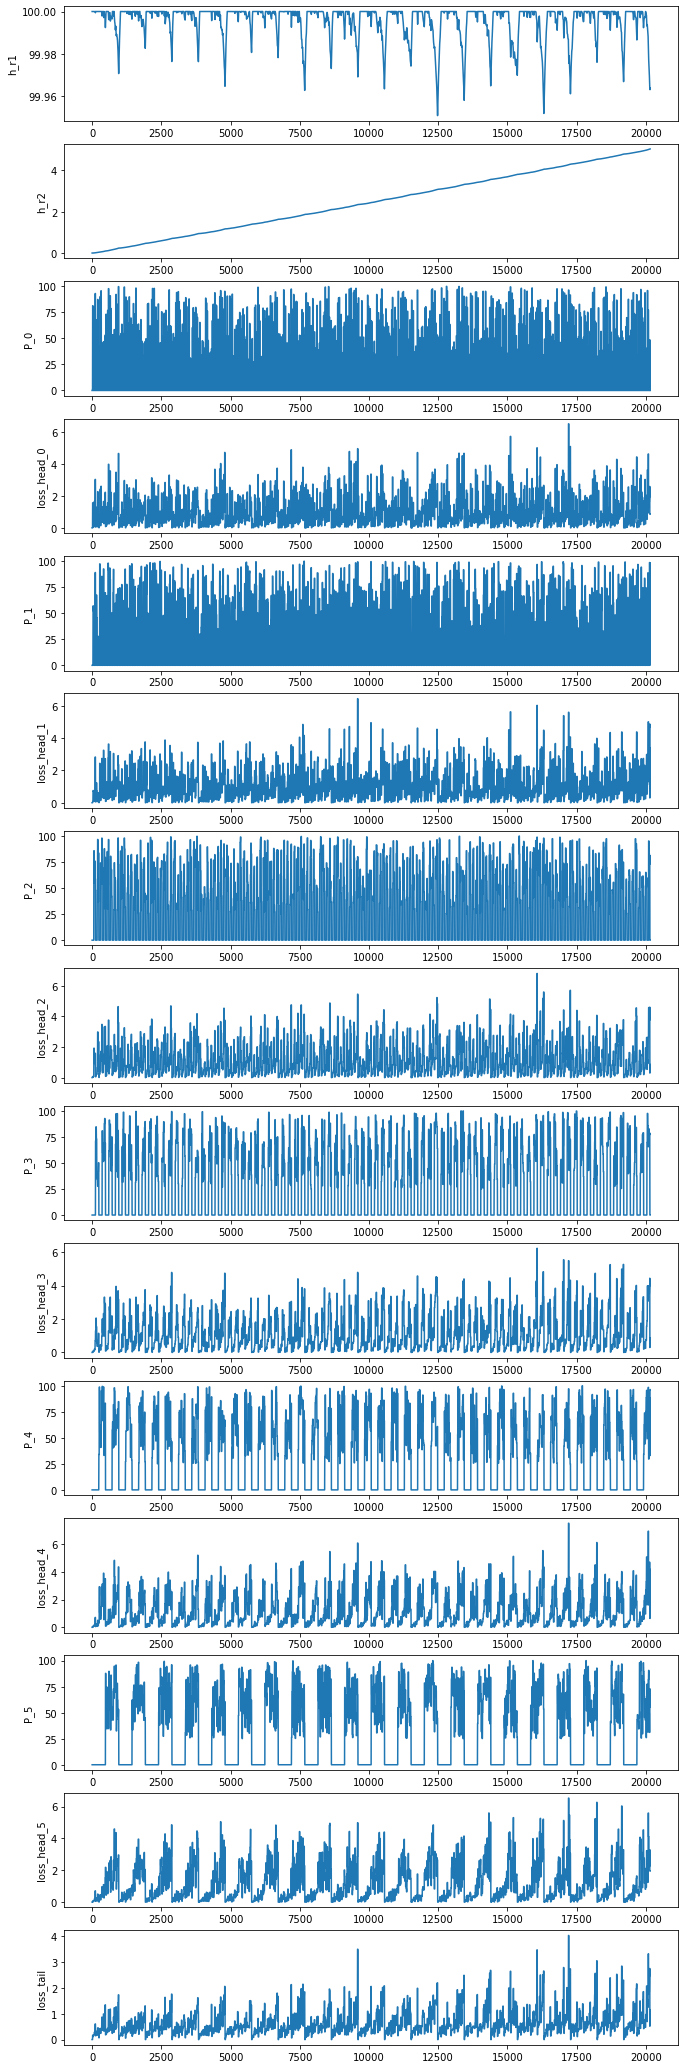

In [5]:
Nplots = len(variables)
jmin = 0      # minimum pixel number
jmax = -1      # maximum pixel number, set to -1 to include all
fig, axs = plt.subplots(Nplots, 1, figsize=(11,2.5*Nplots))

for i in range(Nplots):
    axs[i].plot(data[variables[i]].iloc[jmin:jmax])
    axs[i].set_ylabel(variables[i])   

_Oppgave: Svar på flervalgsspørsmål 3 (vist nedenfor) i Canvas._

3. _Hvilke sammenhenger observerer du mellom variablene?_

For a single power plant, the head loss is dependent on the power production. We can inspect the relation with a scatterplot.

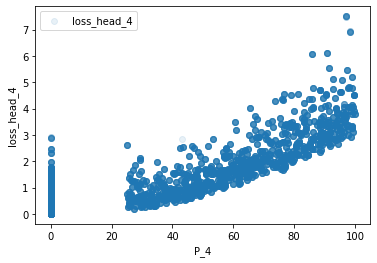

In [6]:
jmin = 0       # minimum pixel number
jmax = -1      # maximum pixel number, set to -1 to include all
fig, axs = plt.subplots()

x_var = 'P_4'
y_var = 'loss_head_4'

axs.scatter(data[x_var].iloc[jmin:jmax], data[y_var].iloc[jmin:jmax], alpha=0.1, label=y_var)
axs.set_xlabel(x_var)
axs.set_ylabel(y_var)
plt.legend()

_Oppgave: Svar på flervalgsspørsmål 4 (vist nedenfor) i Canvas._

4. _Sammenhengen mellom tapet i generator 3 (loss_head_3) og den produserte kraften (P_3) er …_

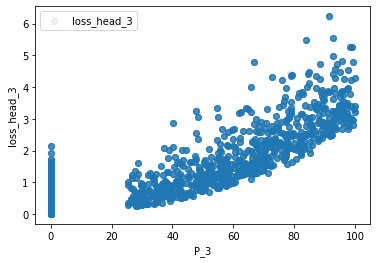

In [7]:
jmin = 0       # minimum pixel number
jmax = -1      # maximum pixel number, set to -1 to include all
fig, axs = plt.subplots()

x_var = 'P_3'
y_var = 'loss_head_3'

axs.scatter(data[x_var].iloc[jmin:jmax], data[y_var].iloc[jmin:jmax], alpha=0.1, label=y_var)
axs.set_xlabel(x_var)
axs.set_ylabel(y_var)
plt.legend()

Plotting all the variables as functions of each other is another way to check for outliers and simple relationships. The order of the plots is the same as in «variables», and if you want to study specific relations, you can replace `vars=variables` with your own list of variables to explore.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


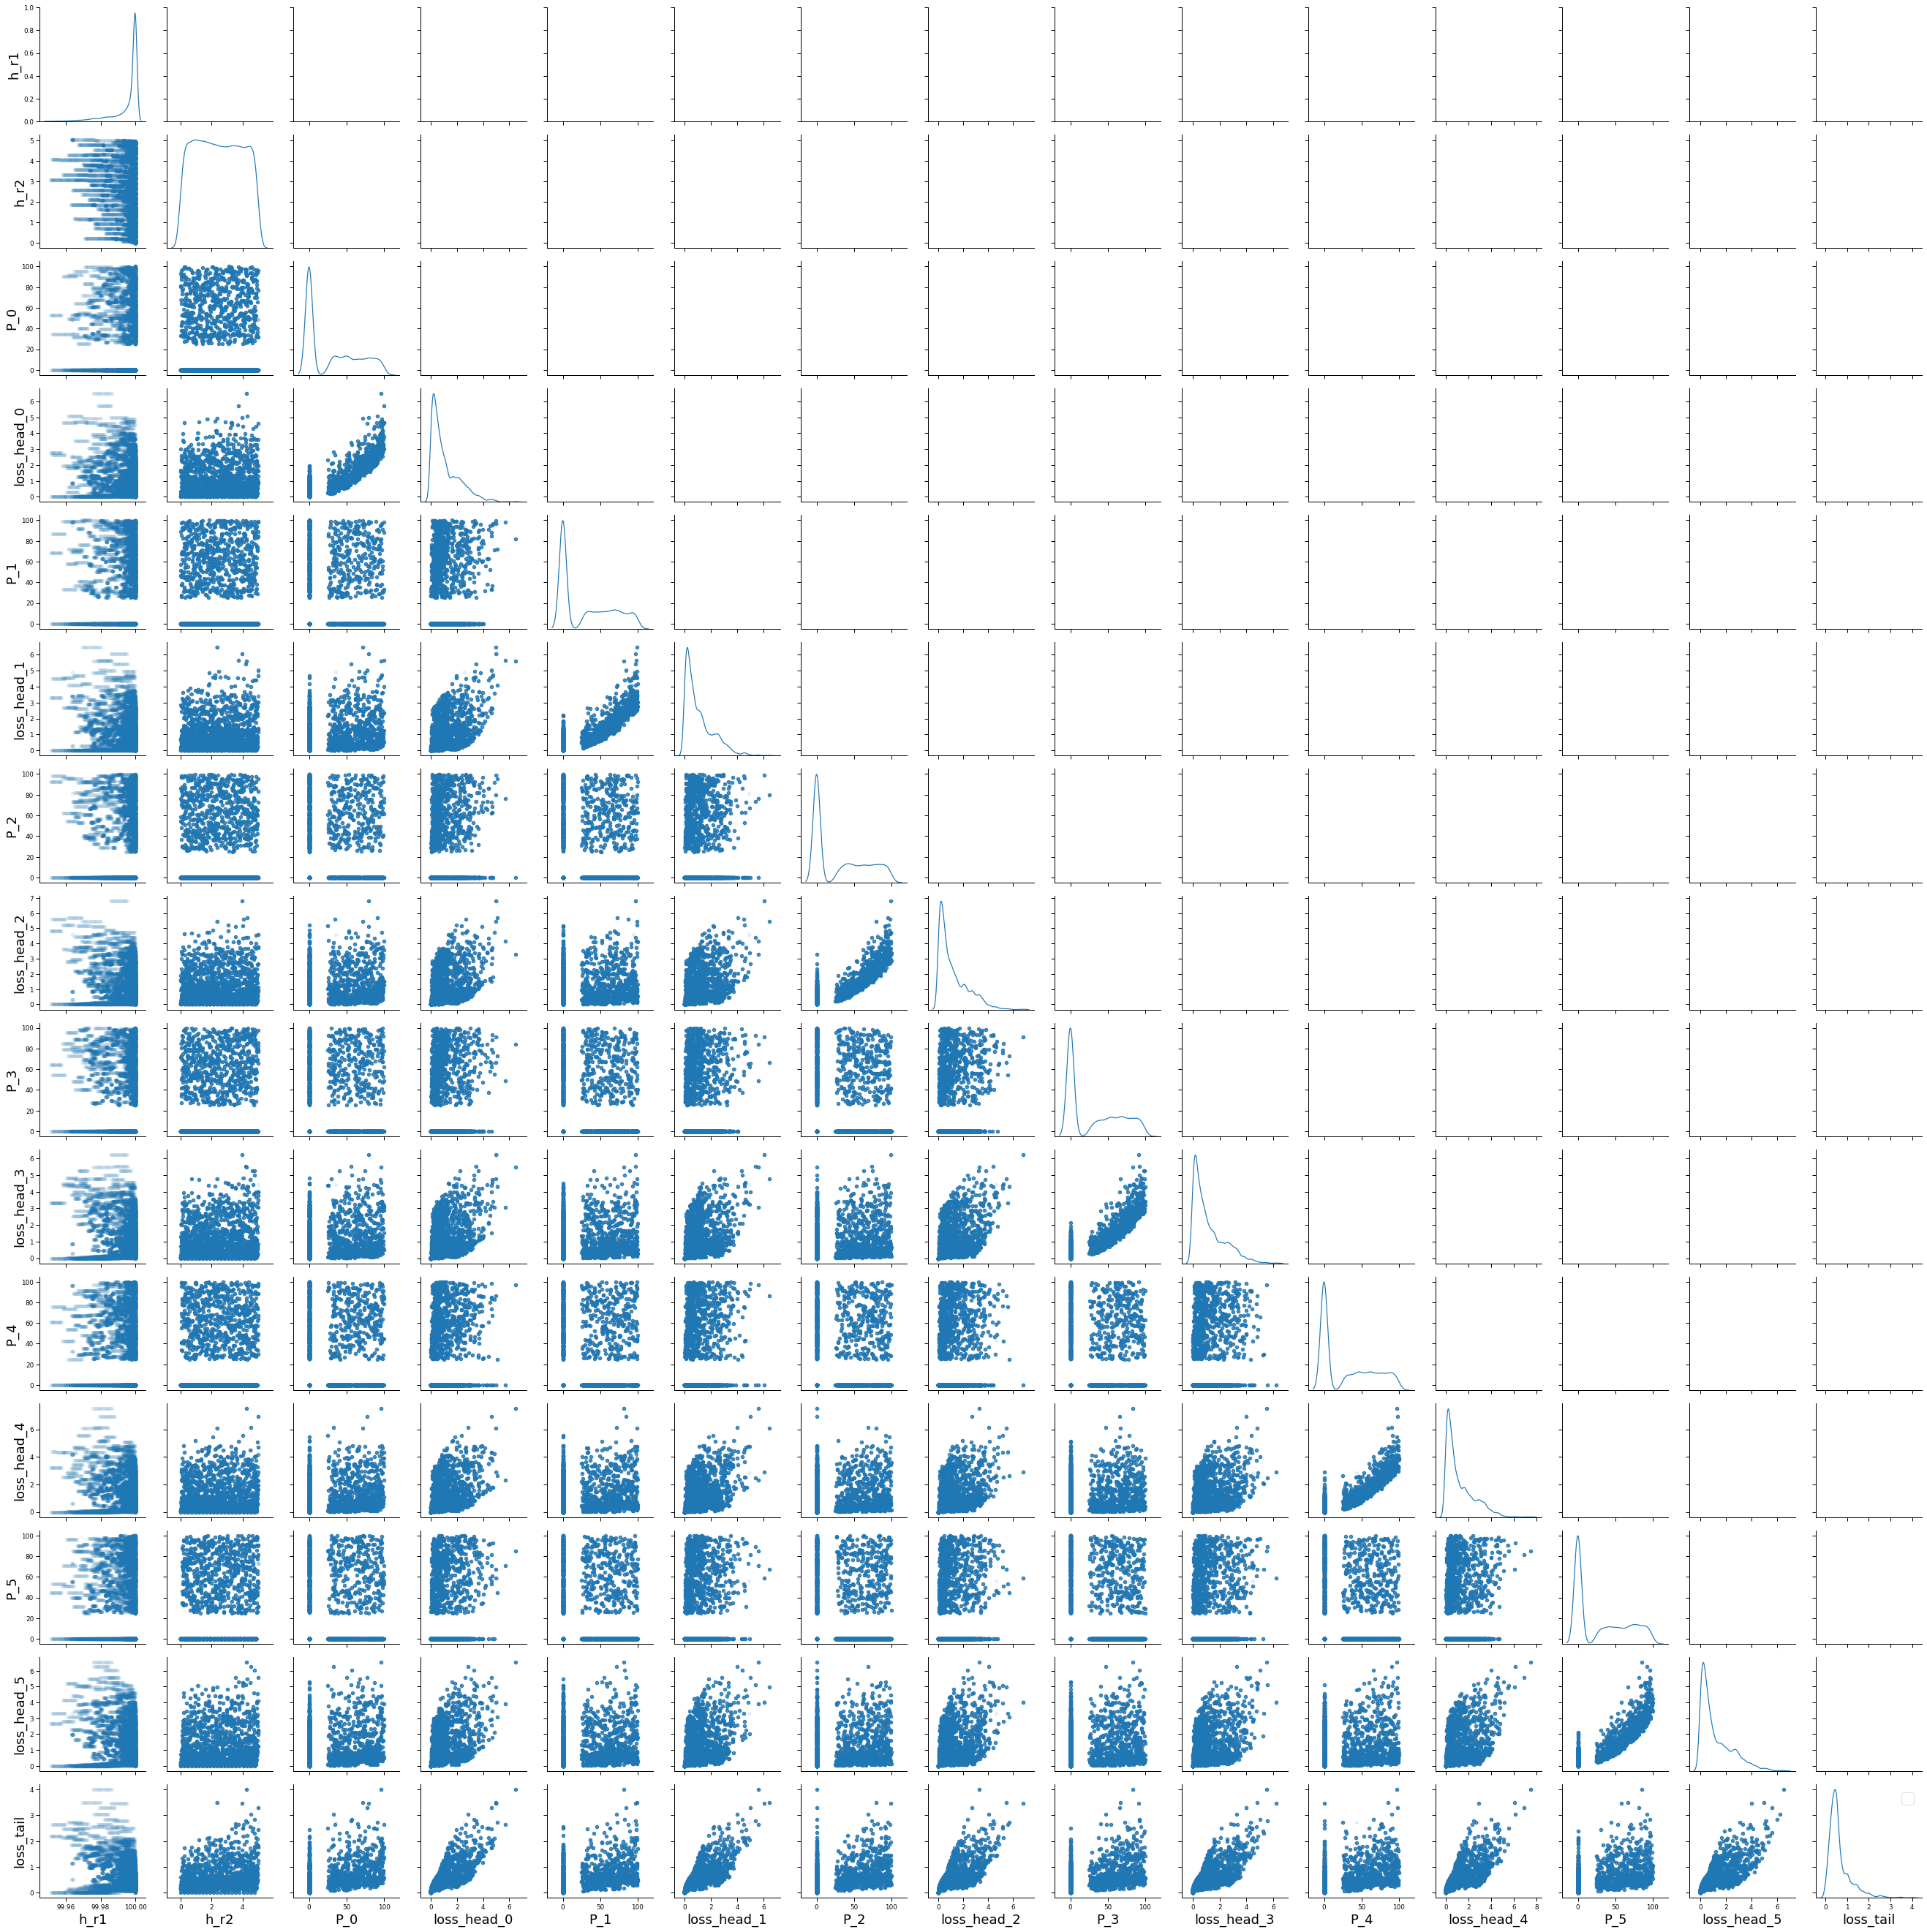

In [8]:
# Visualising data dependencies with seaborn, might take a couple of minutes to run 

sns.set_context("paper", rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":18})  # Formatting font sizes on plots   

# Create the pairgrid object
grid = sns.PairGrid(data=data, vars=variables, diag_sharey=False)
# Upper is a scatter plot
grid.map_lower(plt.scatter, alpha=0.1, s=20)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)
# Bottom is density plot
#grid.map_upper(sns.kdeplot)
#plt.savefig('/gridmap.pdf')
plt.legend(fontsize='large')

plt.show()

_Oppgave: Svar på flervalgsspørsmålene 5–7 (vist nedenfor) i Canvas._

5. _I par-plottet, der alle variablene stilles opp mot hverandre, ser du at noen plott har loddrette og vannrette «linjer» av data. Hva indikerer disse linjene?_
6. _Skal vi fjerne dataene som bidrar til linjene?_
7. _Se på scatterplottet av produksjon i generator 0 og 5. Hvilket forhold er det mellom produksjonen i generator 0 og 5?_

Apart from the vertical lines, we can also look for outliers in the scatter plot. If you spot data points that are looking like outliers, the density distributions plotted along the diagonal are a good help to determine if the potential outliers have the potential to ruin your model. If the individual data points are clearly visible in the density distributions, they are potentially harmful. We can also check that no values are above the maximal production of the generators, etc. But since these are simulated data, all of this has already been taken care of.

### Correlation
Variable correlation is a quick way to check which variables are important for the analysis. A trained eye will often spot the correlations from the gridplot above, but still, a quantification can be useful. We use a Spearman correlation since we do not know if the relationship between parameters is linear (Pearson correlation assumes linearity), and we are not interested in absolute values of correlations but rather the relative correlation.

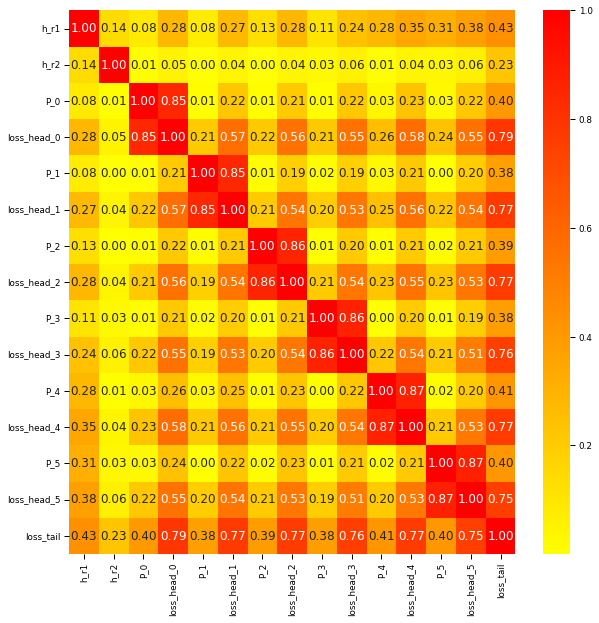

In [9]:
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12})  #Formatting font sizes on plots   

# Create correlation matrix
corr_matrix = data[variables].corr(method='spearman')
# Plot
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(abs(corr_matrix), annot=True, cmap = plt.cm.autumn_r, fmt='.2f', ax=axs)
fig.show()

_Oppgave: Svar på flervalgsspørsmålene 8 og 9 (vist nedenfor) i Canvas._

8. _Kan vi utelukke noen variabler fra videre modellering av alle tapene basert på korrelasjonsplottet?_
9. _Er det noen variabler vi kan utelukke hvis vi kun vil modellere tapet i generator 5?_

### Select the input and output features
*Choose the variables/features you want to investigate with machine learning (fill in/remove in the cell below)*. If you later change the input and output features, you have to run all subsequent boxes to see the new result.

In [10]:
X_var = ['h_r1', 'h_r2', 'P_0', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5']
y_var = ['loss_head_0', 'loss_head_1', 'loss_head_2', 'loss_head_3', 'loss_head_4', 'loss_head_5', 'loss_tail']
variables = X_var + y_var

#### Feature engineering
«Feature engineering» means selecting and combining relevant variables of the problem you are investigating in order to optimally exploit the available information in the data.

From the correlation matrix we can see if the variables of interest are correlated. If some of the independent variables are un-correlated with the dependent variable(s) of interest, they can be removed. If some of the independent variables are correlated with each other, they can either be removed or, even better, combined.

Here, it would make sense to construct a new feature describing the entire power production.

In [11]:
# Addition of variables
data['P_tot'] = data.P_0 + data.P_1 + data.P_2 + data.P_3 + data.P_4 + data.P_5

Here we will continue with the original variables as features, but there are many ways we can generate new features. Some examples are:

- Principal component analysis to remove correlation.
- Use physical knowledge to take the time dimension into account. There could e.g. be some delay between some variable changes. Consequently, it might be better to shift some variables by a short amount of time to get a variable called X-t.
- Use physical knowledge to enforce relationsships between variables.

Feature engineering is often an interactive process where we go back and forth between data pre-processing, correlations, feature engineering and model fitting.

In [12]:
# Code examples of how new features can be generated

# Shift variable backwards by two timesteps
data['P_0-t'] = data.P_0.shift(periods=2)

# Take difference of a variable
data['dP_0_dt'] = data.P_0.diff()

# Notice that the first rows for each new time series will then have "NaN" values for
# the shifted/difference parameter. Dropping all rows with improper values (NaNs)
data.dropna(inplace=True)

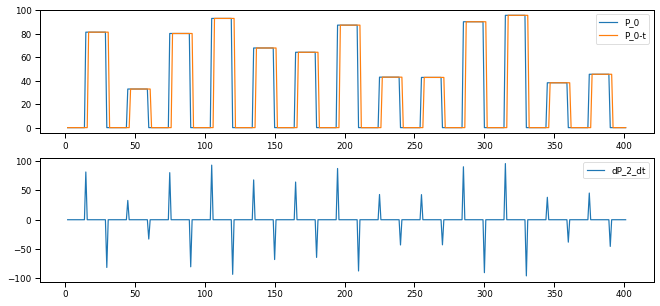

In [13]:
jmin = 0        # minimum pixel number
jmax = 400      # maximum pixel number, set to -1 to include all
fig, axs = plt.subplots(2, 1, figsize=(11,5))

axs[0].plot(data['P_0'].iloc[jmin:jmax], label='P_0')
axs[0].plot(data['P_0-t'].iloc[jmin:jmax], label='P_0-t')
axs[0].legend()

axs[1].plot(data['dP_0_dt'].iloc[jmin:jmax], label='dP_2_dt')
axs[1].legend()

*Construct a couple of new features/variables based on the examples above (hint: edit the code above and rerun the cell)*.

### X features
The last step is to create a new list with the features we want to use in the modelling.

In [14]:
X_feat = X_var + ['P_tot']
y_feat = y_var

features = X_feat + y_feat
features

['h_r1',
 'h_r2',
 'P_0',
 'P_1',
 'P_2',
 'P_3',
 'P_4',
 'P_5',
 'P_tot',
 'loss_head_0',
 'loss_head_1',
 'loss_head_2',
 'loss_head_3',
 'loss_head_4',
 'loss_head_5',
 'loss_tail']

### Training and test data

Before we can train a model, we need to split the data into a training sample and a test sample. This is done so that we can check the validity of the model on data that has not been used in the training. If the model performs very well on the training data, but not so well on the test data, it has not learned to generalise, and we say that it is overfitting. This is related to something called the bias-variance trade off. It describes the balance between the right amount of complexity in the model and the ability to generalise.


![Bias-variance trade off](figures/bias_variance.png)

We must also split out a sample to use for tuning the model. This is called the validation data. We want the validation to take place on chronological data rather than the randomized training data.

*Choose the fraction of data we want to use for test and validation. The default value of 0.1 is not meaningful!*

In [15]:
train_frac = 0.6              # Fraction of total data for training
test_frac = 1 - train_frac      # Reserved for testing. Not used in training
val_frac = 0.2                  # Fraction of training data used during training for tuning of hyperparameters

In [16]:
train_split_index = int(train_frac*len(data))
val_split_index = int(val_frac*train_split_index) 
# We split out the validation data rather than using the validation_split variable in keras, since we want the 
# validation to take place on chronological data rather than the randomized training data

data_train = data.iloc[:train_split_index]
data_test = data.iloc[train_split_index:]
data_val = data.iloc[train_split_index-val_split_index:train_split_index]      

### Visualising the split (on the dependent variables)

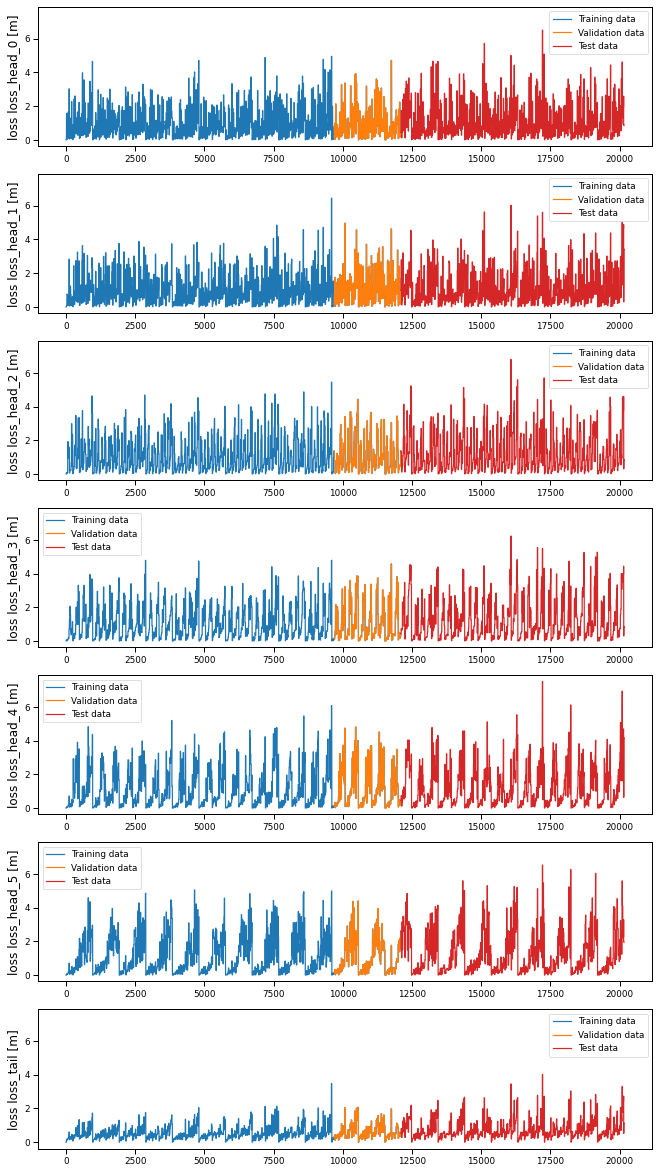

In [17]:
Nplots = len(y_feat)
fig, axs = plt.subplots(Nplots, 1, figsize=(11,3*Nplots), sharey=True)

for i in range(Nplots):
    axs[i].plot(data_train[y_feat[i]], label='Training data')
    axs[i].plot(data_val[y_feat[i]], label='Validation data')
    axs[i].plot(0,0)
    axs[i].plot(data_test[y_feat[i]], label='Test data')
    axs[i].set_ylabel(f'loss {y_feat[i]} [m]')
    axs[i].legend()
        

_Oppgave: Svar på flervalgsspørsmål 10 (vist nedenfor) i Canvas._

10. _Hva er det viktig å tenke på når man splitter data i trenings-, validerings- og testsett?_

In [18]:
# Renaming. This box has no output
X_train = data_train[X_feat]
y_train = data_train[y_feat]
X_val = data_val[X_feat]
y_val = data_val[y_feat]
X_test = data_test[X_feat]
y_test = data_test[y_feat]

In [36]:
# To see that the box above actually executed, we can print the size of the array
print(np.shape(X_train))

(12094, 9)


### Feature scaling
Not all features have the same scale. Look at the y-axes on the plots: Some have values of the order of 1000s, and some are 0.1. In order to let them equally influence the model, we need to "put everything on the same scale". We can either scale everything to a fixed range of values (MinMaxScaler) or change the distribution to become a normalised Gaussian (StandardScaler).

When chosing the scaling it is important to prevent data leakage. So we cannot scale the training data with something that depends on the test data. Ideally, the training, validation and test data have the same underlying distribution and are hence statistically representative of each other and the scalings based on either sample will be identical. As a rule of thumb it is usually safe to apply the scaling from the training data to all data.
Depending on the sample size, the test data can either be scaled with their own scaling (for large samples), or with the training sample (small samples). The choice also depends on how you would treat the actual data you will later use with the model.

![Original data, zero-centered data and normalized data](figures/original-zeroed-normalized.png)

Source: https://www.kdnuggets.com/2018/10/notes-feature-preprocessing-what-why-how.html

In [20]:
# Feature scaling, this box does not provide any output
sc_X = MinMaxScaler(feature_range=[0,1])
sc_y = MinMaxScaler(feature_range=[0,1])
X_train_scaled = pd.DataFrame(sc_X.fit_transform(X_train.values), columns=X_feat)
y_train_scaled = pd.DataFrame(sc_y.fit_transform(y_train.values), columns=y_feat)
X_val_scaled = pd.DataFrame(sc_X.transform(X_val.values), columns=X_feat)
y_val_scaled = pd.DataFrame(sc_y.transform(y_val.values), columns=y_feat)
X_test_scaled = pd.DataFrame(sc_X.transform(X_test.values), columns=X_feat)

_Oppgave: Svar på flervalgsspørsmålene 11 og 12 (vist nedenfor) i Canvas._

11. _Hva gjør min-maks-skaleringen?_
12. _Hvilken skalering skal du vanligvis benytte på testdataene dine?_

In [37]:
X_train_scaled

,h_r1,h_r2,P_0,P_1,P_2,P_3,P_4,P_5,P_tot
0,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
12089,1.0,0.999661,0.0,0.479751,0.593941,0.0,0.0,0.861782,0.409947
12090,1.0,0.999746,0.0,0.479751,0.593941,0.0,0.0,0.861782,0.409947
12091,1.0,0.999831,0.0,0.479751,0.593941,0.0,0.0,0.861782,0.409947
12092,1.0,0.999915,0.0,0.479751,0.593941,0.0,0.0,0.861782,0.409947


In [38]:
y_train_scaled

,loss_head_0,loss_head_1,loss_head_2,loss_head_3,loss_head_4,loss_head_5,loss_tail
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
12089,0.087159,0.152069,0.249179,0.090179,0.071044,0.516105,0.155402
12090,0.087159,0.152070,0.249180,0.090179,0.071044,0.516108,0.155402
12091,0.087160,0.152071,0.249182,0.090180,0.071045,0.516111,0.155402
12092,0.087160,0.152072,0.249183,0.090181,0.071045,0.516114,0.155402


## Neural network


### Defining the neural network
We use the Keras framework with the TensorFlow backend to define the network (if you have no idea what that sentence is about, don't worry too much). TensorFlow may provide some warnings about architechture that can be ignored for our purpose.

It will take the X-features as input and provide the y-estimates as output.

In [39]:
dropout_frac = 0.2
number_neurons1 = 8
number_neurons2 = 4
number_neurons3 = 8

model = Sequential()
model.add(Dense(units=number_neurons1, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(dropout_frac))  # Preventing overfitting
model.add(Dense(units=number_neurons2, activation='relu'))
model.add(Dropout(dropout_frac))  # Preventing overfitting
model.add(Dense(units=number_neurons3, activation='relu'))
model.add(Dropout(dropout_frac))  # Preventing overfitting
model.add(Dense(units=y_train.shape[1], activation='linear'))

model.compile(loss='mean_squared_error', metrics=['accuracy'], optimizer='adam')

### Visualisation of a neural network
A Keras neural network can be visualized with the ann_visualizer module. However, the module is not included in our installation, so we simply show an image of the initial network. An alternative to creating a figure inside the notebook, is to use online visualisers like http://alexlenail.me/NN-SVG/index.html.

In case you want to try the module at a later time, install the package and use these two lines of code to create a pdf:
```
from ann_visualizer.visualize import ann_viz
ann_viz(model, title='')
```
![Neural network visualization](figures/network.gv.png)

In [56]:
from ann_visualizer.visualize import ann_viz
ann_viz(model, title='asdf')

ModuleNotFoundError: No module named 'keras'

### Dropout
Dropout layers help against overfitting by «dropping» neurons during training. For each epoch a certain fraction of randomly selected neurons are ignored, effectively leaving a reduced network to train. This forces the network to actively use more neurons while training, and consequently reduces the risk of getting stuck in local minima. A high fraction of dropout may lead to the counterintuitive situation where a network will provide a better fit on the validation data than on the training data (because no neurons are dropped during the prediction).

### Training the model
This may take a couple of minutes if the network is large.

The relevant hyperparameters are:

- **Epochs**: The number of times the weights in the network will be updated. The value should be large enough for the network to converge (minimize loss to a stable level). If you run the training again without redefining the network, the training will continue from the previous session.
- **Batch size**: Determines the number of samples for cross-validation. Generally you should use as small a batch size as patience/available computing time allows for.
- **Callbacks**: A smart way to plot the loss during training. Requires the `aux_functions.py`

*Choose some values for the hyperparameters and train the network. The suggested amount of 5 is very small*

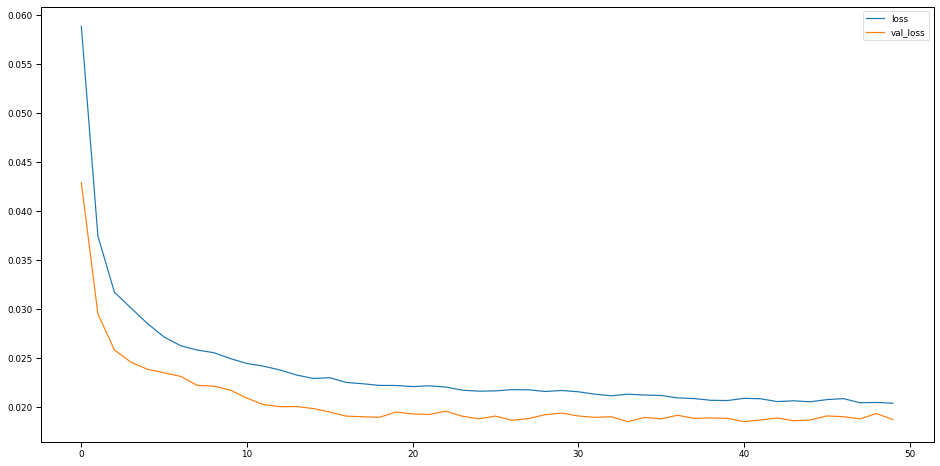

In [41]:
training_history = model.fit(X_train_scaled, y_train_scaled, 
                             validation_data=(X_val_scaled, y_val_scaled), 
                             epochs=50,                  
                             batch_size=200,    
                             callbacks=[plot_losses])

The figure shows the loss computed on the training sample and the validation sample. The loss is the quantity the neural network aims to minimize. When the training loss (blue) is decreasing, the fit is improving on the training data. The validation loss tells how well the model is generalising to unseen data (the validation sample). When it is decreasing, the model performance is improving, but when it starts increasing, the model is overfitting to the training data.

_Oppgave: Svar på flervalgsspørsmål 13 (vist nedenfor) i Canvas._

13. _Noen ganger blir validerings-tapsfunksjonen MINDRE enn trenings-tapsfunksjonen. Hva kan det skyldes?_

### Using the model to predict the test data
Remember that we scaled the input and output data before training the model. Now we need to rescale the predictions before we compare to the actual values from the test data.

In [42]:
y_scaled = model.predict(X_test_scaled)  # Predicting
y_pred_NN = pd.DataFrame(sc_y.inverse_transform(y_scaled), columns=y_feat)  # Rescaling

### Plotting the results
Compare the predicted results with the test data y values. 

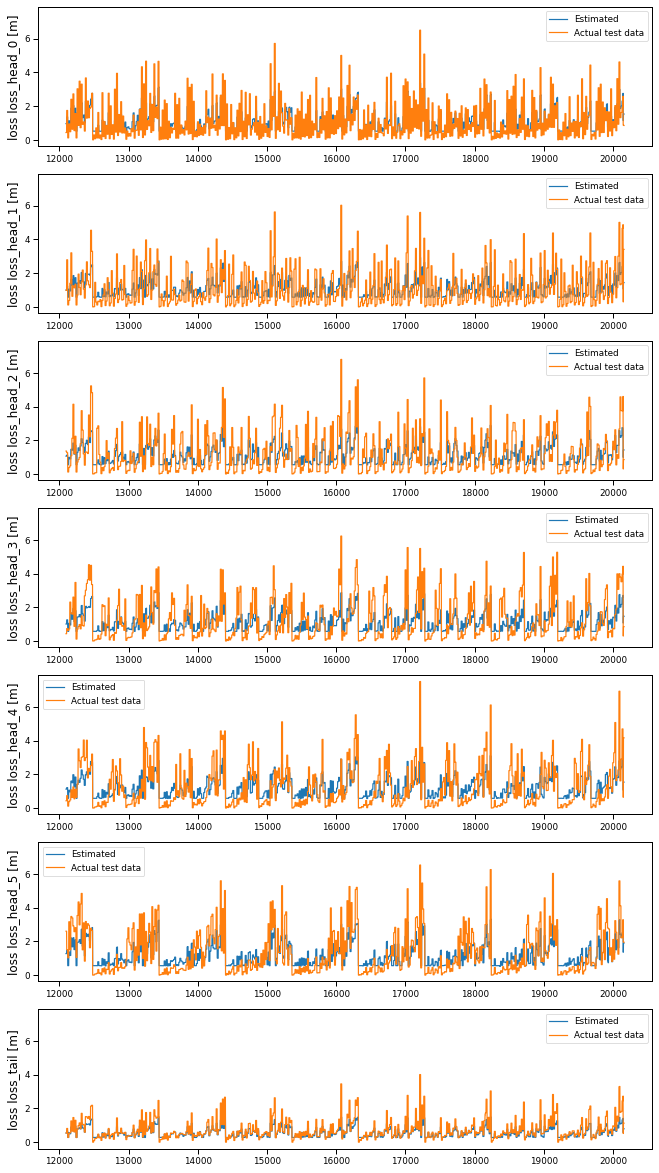

In [43]:
Nplots = len(y_var)
fig, axs = plt.subplots(Nplots, 1, figsize=(11,3*Nplots), sharey=True)

for i in range(Nplots):
    axs[i].plot(y_test[y_feat[i]].index, y_pred_NN[y_feat[i]].values, label = 'Estimated')
    axs[i].plot(y_test[y_feat[i]].index, y_test[y_feat[i]].values, label = 'Actual test data')
    axs[i].set_ylabel(f'loss {y_feat[i]} [m]')
    axs[i].legend()

Visually, the model prediction and the data are close. However, it seems that the network tends to underestimate higher value and overstimate lower values. This is typical of an error-minimisation/least-squares approach.

_Oppgave: Svar på «Vi spør – du svarer»-spørsmålene 1 og 2 (vist nedenfor) i Canvas._

1. _Hva kan du gjøre for å forbedre modellen?_
2. _Hva er den største faren ved blindt å øke antall nevroner?_

*Try to improve the network performance by changing the network architechture (increase number of neurons and/or layers, experiment with different-sized layers).*

*Try different feature scalings (MinMaxScaler, StandardScaler) or different values for the hyperparameters.*

## Quantification of model performance
After having trained a neural network and obtained a prediction, we should evaluate the model performance. The criteria will always depend on the problem, but in this case we will use the standard measure of mean squared error between the prediction and the test data for one feature: $MSE = \frac{1}{N} \sum (y_{p} - y_{t})^2$, where $N$ is the total number of data points, $y_{p}$ represents the model prediction for the test data input features, and $y_{t}$ represents the test data y-values.

In [44]:
# Selecting one output feature for comparison and converting it to column number
one_y = 'loss_head_0'

In [57]:
mse_NN = np.sum((y_pred_NN[one_y].values-y_test[one_y].values)**2)/len(y_pred_NN[one_y])
print(mse_NN)

0.5602130593923619


_Oppgave: Svar på «Vi spør – du svarer»-spørsmål 3 (vist nedenfor) i Canvas._

3. _Når man jobber med en modell, er det lurt å holde styr på hvor god ytelse modellen får med ulike hyperparametere. Noter den beste ytelsen du har oppnådd for loss_head_0 (lavest mean squared error på testdataene), samt struktur og hyperparametere for denne modellen._

## XGBoost

Neural networks are super flexible, but not very transparent. If we're interested in the importance of the individual parameters, a better methods may be decision tree based. XGBoost is an easy-to-use and yet very powerful implementation. However, one disadvantage is that XGBoost can only handle single output regression. Hence, in this example we will focus on one output instead of six.

XGBoost is based on a concept called gradient boosted trees. It is explained here: https://www.youtube.com/watch?v=TyvYZ26alZs. The documentation for XGBoost has also a very nice and concise description: https://xgboost.readthedocs.io/en/latest/tutorials/model.html.

_Oppgave: Svar på flervalgsspørsmål 1 (vist nedenfor) i Canvas, fra neste oppgavesett («Veiledet regresjon, trebaserte modeller»)._

1. _Hva karakteriserer gradient boosted trees?_

### Preprocessing
We can use the same preprocessing as above, but we need to reduce the output to one variable.

In [58]:
# Selecting one output variable and converting it to column number
one_y = 'loss_head_0'

In [59]:
# Selecting output and scaling
sc_y_boost = MinMaxScaler(feature_range=[0,1])
y_train_boost = y_train[one_y].values.reshape(-1, 1)  # reshaping to conform with scikit learn notation
y_train_boost_scaled = pd.DataFrame(sc_y_boost.fit_transform(y_train_boost), columns=[one_y])
y_test_boost = y_test[one_y]

In [70]:
y_train_boost

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.43170776],
       [0.43171023],
       [0.43171271]])

In [71]:
y_train_boost_scaled

,loss_head_0
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
12089,0.087159
12090,0.087159
12091,0.087160
12092,0.087160


### Setting up XGBoost
XGBoost has a lot of hyperparameters. You can read about all the hyperparameters in the XGBoost documentation https://xgboost.readthedocs.io/en/latest/parameter.html. Here we focus on:

- **max_dept**: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. Value in [0, infinity] (2).
- **num_parallel_tree**: Number of parallel trees created for each episode to improve the existing model. Value in [0, infinity] (3).
- **min_split_loss [aka gamma]**: Minimum loss reduction required to make a further partition on a leaf node of the tree. Value in [0, infinity] (0). 
- **learning_rate [aka eta]**: After each boosting step, we can directly get the weights of new features, and the learning_rate shrinks the feature weights to make the boosting process more conservative. Value in [0, 1] (0.1).
- **objective**: Which loss function to use. As for the neural network, we will use the mean squared error.

We will start out with the hyperparameter values indicated in parentheses after each explanation. In addition, XGBoost needs to know how many trees to add to the model. This is called **num_boost_round** and can be passed directly to xgb.train(). If we do not define anything, XGBoost will find the optimal value automatically (you can read how here: https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f).

In [72]:
params = {'learning_rate': 0.1, 'max_depth': 2, 'min_split_loss': 0.0, 'num_parallel_tree': 3, 'objective':'reg:squarederror'}
xgb_model = xgb.train(params=params, 
                       dtrain=xgb.DMatrix(X_train_scaled, label=y_train_boost_scaled))

In [74]:
X_train_scaled

,h_r1,h_r2,P_0,P_1,P_2,P_3,P_4,P_5,P_tot
0,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
12089,1.0,0.999661,0.0,0.479751,0.593941,0.0,0.0,0.861782,0.409947
12090,1.0,0.999746,0.0,0.479751,0.593941,0.0,0.0,0.861782,0.409947
12091,1.0,0.999831,0.0,0.479751,0.593941,0.0,0.0,0.861782,0.409947
12092,1.0,0.999915,0.0,0.479751,0.593941,0.0,0.0,0.861782,0.409947


In [75]:
y_train_boost_scaled

,loss_head_0
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
12089,0.087159
12090,0.087159
12091,0.087160
12092,0.087160


### Plotting a tree

We can plot an example of the decision trees from the model, but remember that the model consist of many such trees with different weights.

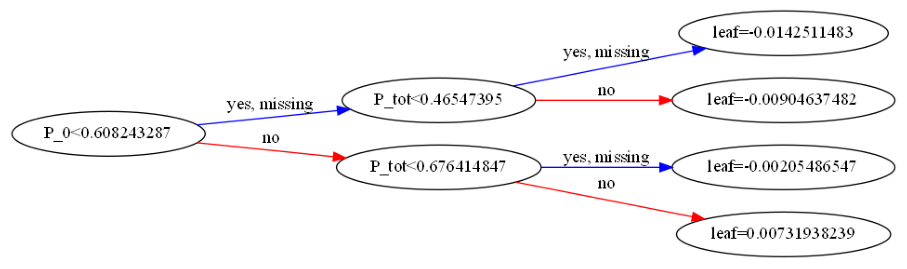

In [82]:
# Drawing the trees one by one (there are n_estimators trees)
plt.rcParams['figure.figsize'] = [16, 8]
#xgb.plot_tree(model, num_trees=0)
xgb.plot_tree(xgb_model, num_trees=1, rankdir='LR')
# If using pandas dataframes instead of numpy arrays, the plot will use dataframe column 
# names in the graph instead of f1,f2,… etc
plt.show()

_Oppgave: Svar på flervalgsspørsmål 2 (vist nedenfor) i Canvas._

2. _Hvilken feature er den første splitten på?_

### Plotting the model prediction 
Doing the model prediction and unscaling is similar to what we did for the neural network. The main difference is that the model need the data formatted as an XGBoost-matrix, and then we reshape the output to have the same format as our test data.

In [83]:
y_scaled = xgb_model.predict(xgb.DMatrix(X_test_scaled)).reshape(-1, 1)
y_pred = pd.DataFrame(sc_y_boost.inverse_transform(y_scaled), columns=[one_y])  # Rescaling

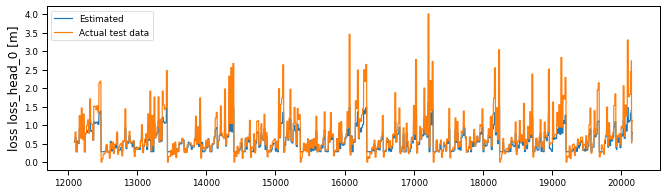

In [84]:
fig, axs = plt.subplots(1, 1, figsize=(11,3))

axs.plot(y_test[y_feat[i]].index, y_pred_NN[y_feat[i]].values, label = 'Estimated')
axs.plot(y_test[y_feat[i]].index, y_test[y_feat[i]].values, label = 'Actual test data')
axs.set_ylabel(f'loss {one_y} [m]')
axs.legend()

### Feature importance
As we have already seen from the simple correlation analysis, not all features have the same importance for the model. For XGBoost we can easily plot the feature importance as defined by the number of times a feature appears in a tree (weight) or the improvements generated by that feature (gain). A more correct way of doing this is using something called SHAP, which we will get back to later in the course.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

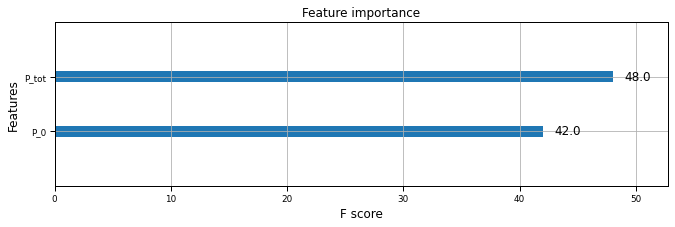

In [89]:
# Plot feature importances
fig, axs = plt.subplots(1, 1, figsize=(11,3))
xgb.plot_importance(xgb_model, ax=axs, importance_type='weight')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

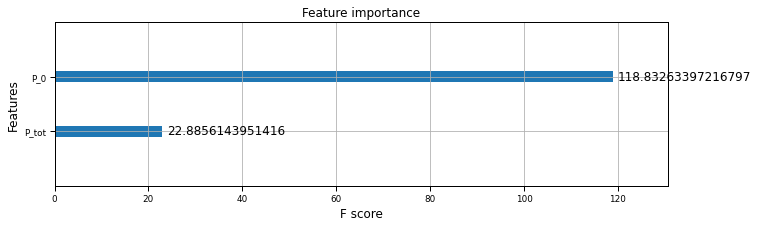

In [86]:
# Plot feature importances
fig, axs = plt.subplots(1, 1, figsize=(11,3))
xgb.plot_importance(xgb_model, ax=axs, importance_type='gain')

_Oppgave: Svar på flervalgsspørsmål 3 og 4 (vist nedenfor) i Canvas._

3. _Hvilken feature er viktigst basert på henholdsvis vekt og «gain»?_
4. _Er det noen features som ikke bidrar til modellen?_

## Quantification of model performance II
We would like to compare the performance of the XGBoost model with the neural network.

In [35]:
mse_NN = np.sum((y_pred_NN[one_y].values - y_test[one_y].values)**2)/len(y_pred_NN[one_y])
print(f'mse_NN for {one_y}:', mse_NN)
mse_xgb = np.sum((y_pred[one_y].values - y_test[one_y].values)**2)/len(y_pred[one_y])
print(f'mse_xgb for {one_y}:', mse_xgb)

mse_NN for loss_head_0: 0.6840170821236582
mse_xgb for loss_head_0: 0.5268165733435347


_Oppgave: Svar på «Vi spør – du svarer»-spørsmål 1 (vist nedenfor) i Canvas, fra neste oppgavesett._

1. _Oppnådde du best ytelse med det nevrale nettverket eller XGBoost for loss_head_0, dvs. lavest mean squared error? Hvorfor tror du den modellen gjorde det best?_